# Applying clustering to identify land use in Satellite imagery

In [256]:
import os

#data manipulation
import numpy as np


#reading and displying images
import matplotlib.pyplot as plt
import seaborn as sns

#the K-means implementation
from sklearn.cluster import KMeans

#guassaian smoothing
from scipy.ndimage import gaussian_filter

#inline plots
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,20)

# The Data

Lets try some satellite images from: https://apps.sentinel-hub.com/sentinel-playground

We load several images to try. One is the natural image; what you see with your eyes.
The others include several different spectra highlighing argicultural, urban and vegetation.

In [164]:
files = ["Sentinel-2 image on 2018-012-natural.jpg",
         "Sentinel-2 image on 2018-01-12-agric.jpg",
         "Sentinel-2 image on 2018-01-12-urban.jpg",
         "Sentinel-2 image on 2018-01-12-vegetation.jpg"
        ]

names = ["Natural",
         "Agricultural",
         "Urban",
         "Vegetation"]

Let's read the files into a dict

In [211]:
file_dir = "../data/ghana_data/"

images = [plt.imread(file_dir + file) for file in files]
images = dict(zip(names, images))

## Pre-processing the image

We can try to pre-process the image by applying a gaussian smoothing function. This will mean we lose some fine detail but we are not interested in that anyway. 

This will give us some idea if pre-processing is best for the images.

In [234]:
smooth_imgs = []

for name in names:
    smooth_imgs.append(gaussian_filter(images[name], sigma = [5,5,0]))
    
smooth_images = dict(zip(names, smooth_imgs))

Ok, let's look at the images

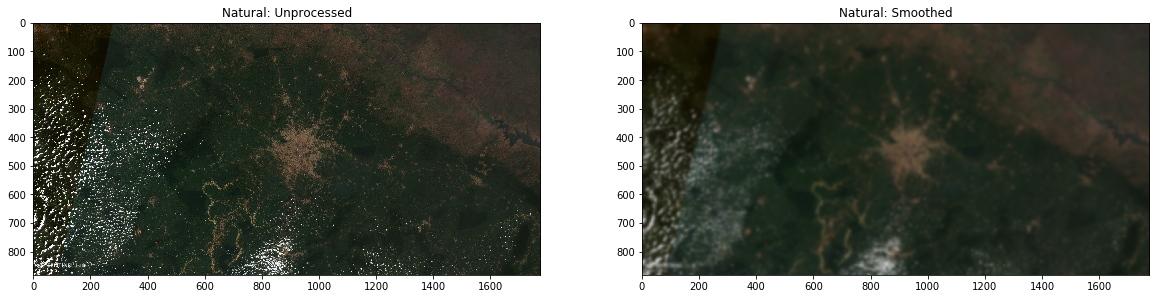

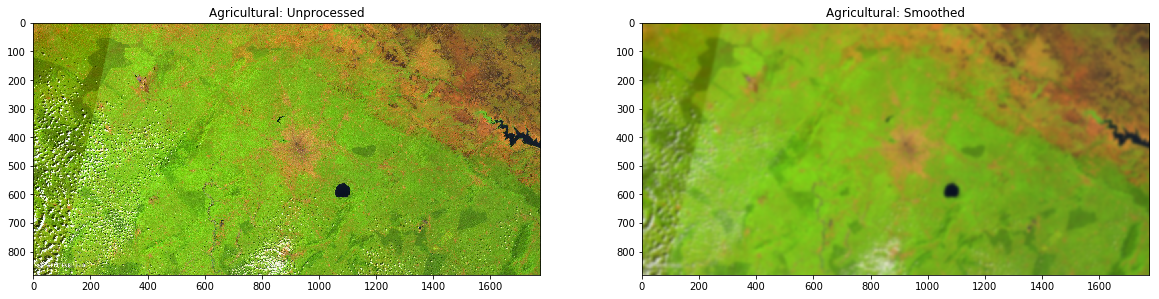

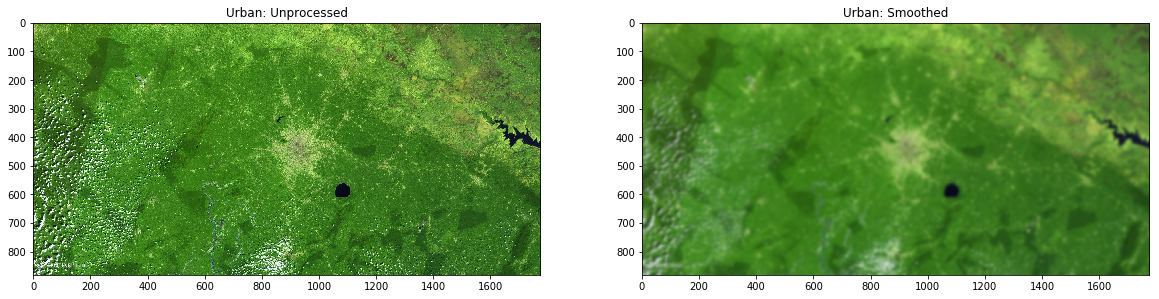

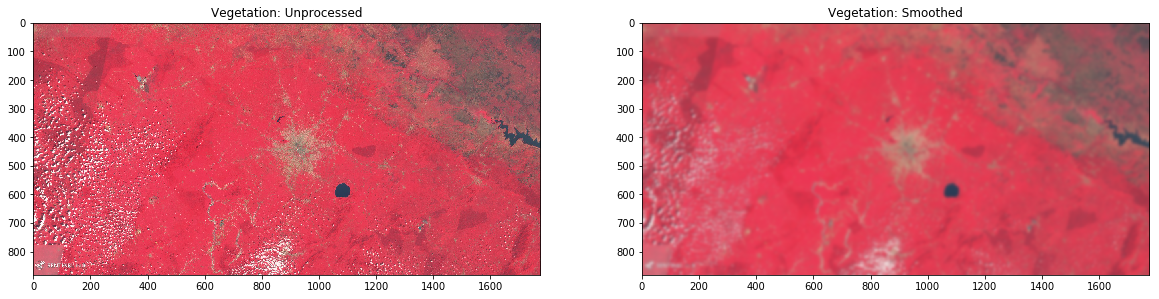

In [259]:

for name in names:
 
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(images[name])
    axs[0].set_title(name + ": Unprocessed")
    axs[1].imshow(smooth_images[name])
    axs[1].set_title(name + ": Smoothed")
    plt.show()

We can see the main city in the centre of the images with a mountainous area in the top and right of the image. The white speckled bits are cloud. Overall it is a pretty clear image, there is a darker region to the left which is where one satellite image has been stitched together with another.

We can see the difference in fine detail lost after the smoothing. But that might suit us as we are not interested in the fine detail

## Clustering

Here we define a function that runs our k-means clustering algorithm. 

Clustering is an unsupervised machine learning approach. This means the data does not contain labels, so we do not tell the algorithm what class a particular observation (in this case a pixel in the image) should have. Instead, the algorithm looks at the distribution of the various features (in our case the amount of red, green and blue of each pixel) and tells us how the data is best grouped into classes.

Clustering algorithms can be sensitive to the starting parameters, so we should try the approach with a few different parameters.

K-Means is a pretty straightfoward approach to clustering.

In K-Means, k is the number of clusters we want it to find, which we define beforehand. As K-Means is sensitive to starting parameters, we will try several different values for K.

The broad steps for the algorithm are as follows

1. Select the centroids for each of the K clusters - this can be done by randomly selecting an observation in our dataset or by defining them beforehand. Here we select them randomly.
2. For each observation, it calculates the euclidian distance in the feature space to the centroid of each cluster each datapoint is assigned to the cluster that has shortest euclidian distance. Simply put: it assigns each datapoint to the closest cluster.
3. The centroids for each cluster are recalculated based upon the mean (hence the name) of the features across all the observations' grouped in that cluster.
4. Repeat from step 2 until a stopping condition is met. Examples of these are: no observation changes cluster, the sum of the euclian distances of each observation and the centroid of its cluster drops below a threshold or a maximum number of iterations is reached.

Below is the code to compute clusters. This uses the scikit-learn implementation of K-Means documented here: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

## Create the functions we need to process the data

Here we create two functions. The first, cluster_image contains the code to run the k-means algorithm on the data. The second runs the k_means with multiple values for k and gets the results

In [168]:
def cluster_image(groups, img, method = "random"):
    """cluster_image
    Takes an image, represented as a numpy array and attempts to cluster the pixels
    in the image into a specified number of groups.
    By default uses random starting clusters with a specified random seed
    
    Args:
        groups (int): The number of groups to cluster the data into (k)
        img (Array): The image of dimensions (x,y,z) where z is the features to cluster over
        method (String): Initial starting method to use, random by default. 
            See: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    
    Returns:
        cluster_labels (Array): Contains cluster labels for img in a 2-D array of the same size as the first two
            dimensions of img
    
    """
    
    #put into the right shape
    dims = np.shape(img)
    img_matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))
    
    #cluster
    cl = KMeans(n_clusters = groups, init = method)
    img_groups = cl.fit_predict(img_matrix)
    
    #create image
    cluster_groups = np.reshape(img_groups, (dims[0], dims[1]))
    
    return cluster_groups

In [260]:
def cluster_ks(image, ks):
    
    """cluster_ks
    Wrapper for cluster image. Repeats clustering for a range of values.
    
    Args:
        image (Array): The image of dimensions (x,y,z) where z is the features to cluster over
        ks (iterable): integer values of k to cluster with
        
    Returns: 
        (dict): key:value pair where key is k clusters and value is the results in a numpy array 
        
    """
    
    cluster_labels = []
    
    for k in ks:
        
        #get cluster groups
        group_labels = cluster_image(groups = k, img = image)
        cluster_labels.append(group_labels)
    
    
    clusters = [str(k) for k in ks]
    return dict(zip(clusters,cluster_labels))

In [266]:
def plt_results(ks, imgs, smoothed_imgs, img_name):
    """plt_results
    
    Plot results from smoothed and unsmoothed images side by side
    
    Args:
        ks (iterable): the value for k used to cluster
        img (dict): cluster results from unsmoothed image
        smoothed_img (dict): cluster results from smoothed image
        img_name (string): name of the image the results are for
        
    Returns:
        figs (List): the figures created from the results
    """

    figs =[]
    for k in range(3,10):
        fig, axs = plt.subplots(1,2)
        axs[0].imshow(imgs[str(k)])
        axs[0].set_title(img_name + ": {} clusters".format(k))
        axs[1].imshow(nat_smooth_results[str(k)])
        axs[1].set_title(img_name + ", smoothed: {} clusters".format(k))
        plt.show()

        figs.append(fig)
        
    return


## Natural image

In [261]:
nat_results = cluster_ks(images["Natural"], range(3,10))
nat_smooth_results = cluster_ks(smooth_images["Natural"], range(3,10))

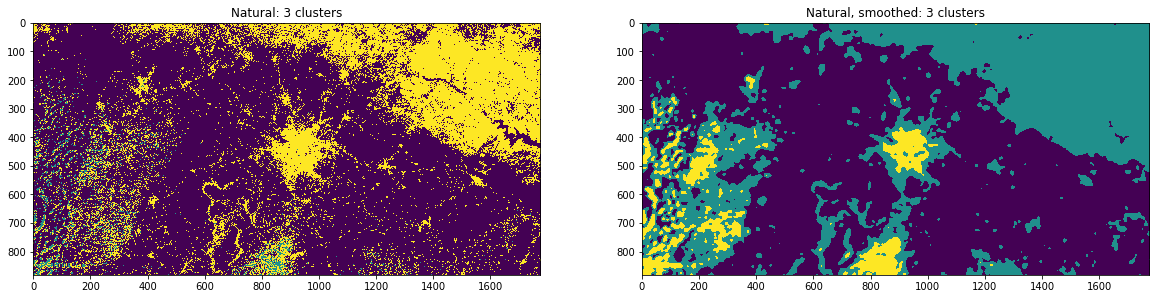

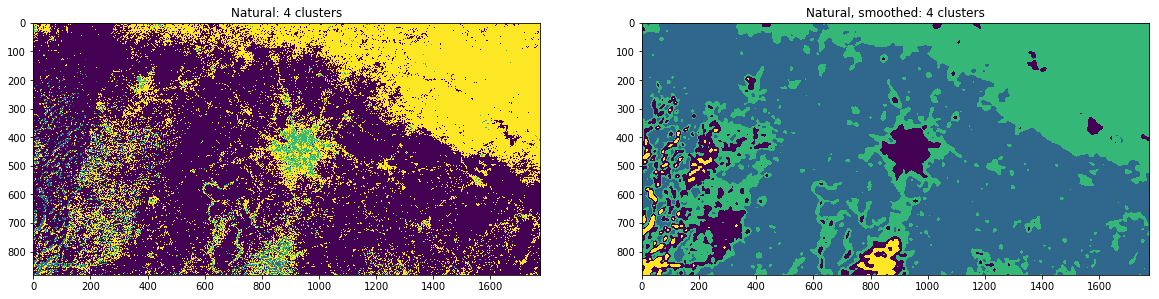

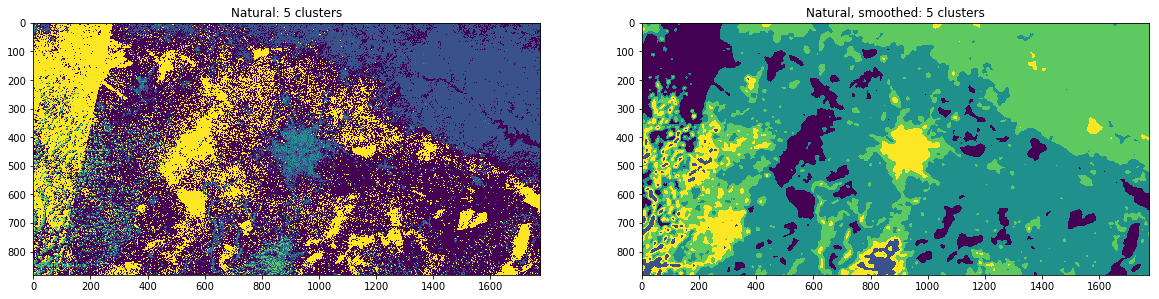

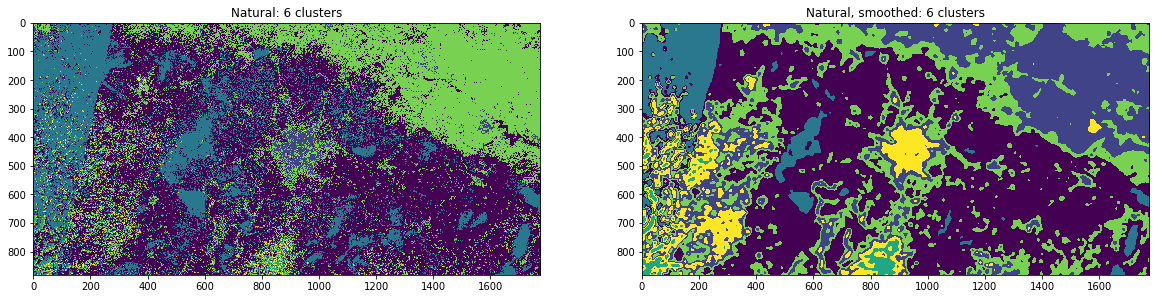

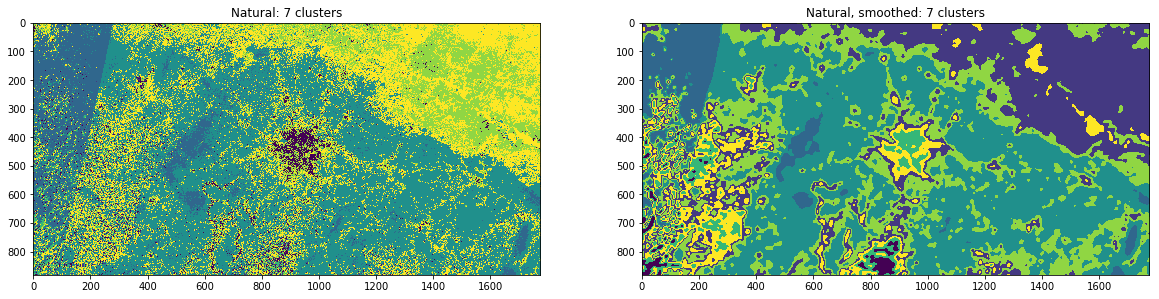

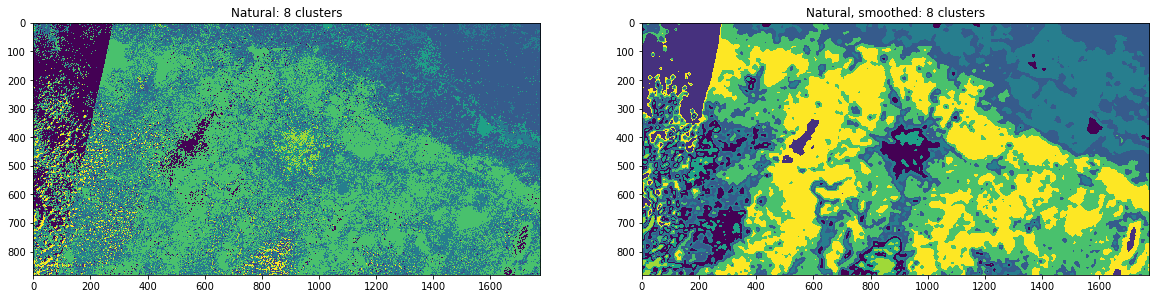

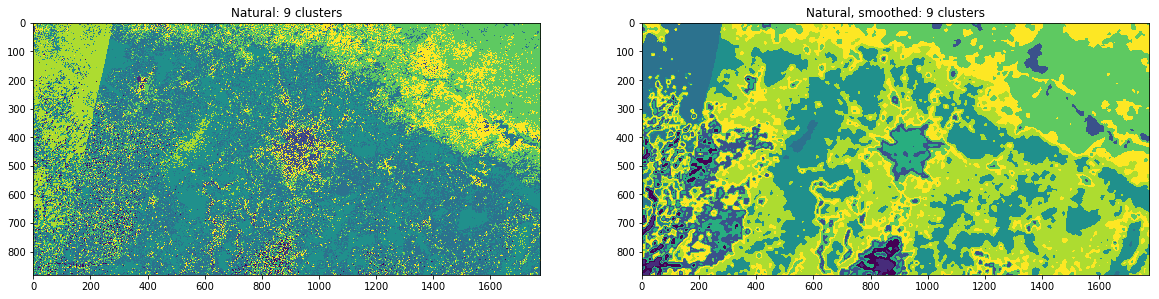

In [268]:
plt_results(ks = range(3,10), 
            imgs = nat_results,
            smoothed_imgs = nat_smooth_results, 
            img_name = "Natural"
           )

### Results

#### Images

The most stark difference is how much noiser our unsmoothed images look. If we wanted to perform some kind of edge detection or segmentation, we could do that on our smoothed images but not the unsmoothed. 

As for picking out the main city. It looks like using three clusters works ok, as do four and five. However, there are still things like clouds and mountains that it is being grouped with,so not perfect.

Six clusters and upwards appear to be less useful and exhibit more noise in the results - not idea for gross segmentation of land use.

We can get some metrics for the amount of land put into each group.

# Agricultural

Lets repeat the steps above with the agricultural image. This image has already been pre-processed to identify some land use which might make our job easier

In [ ]:
agric_results = cluster_ks(images["Agricultural"], range(3,10))
smooth_agric_results = cluster_ks(smooth_images["Agricultural"], range(3,10))

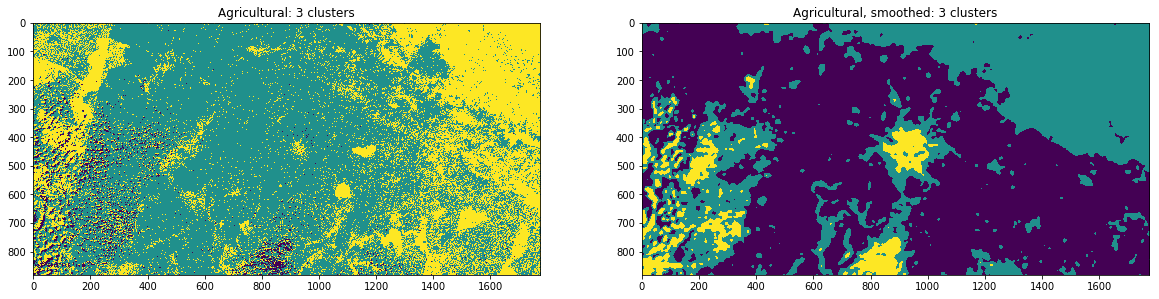

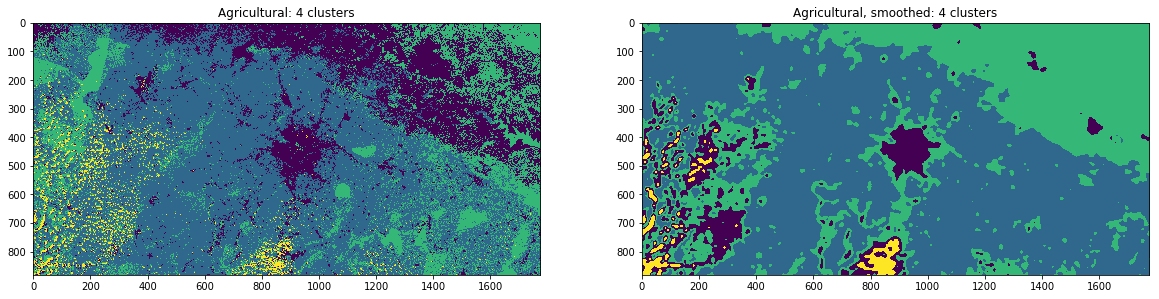

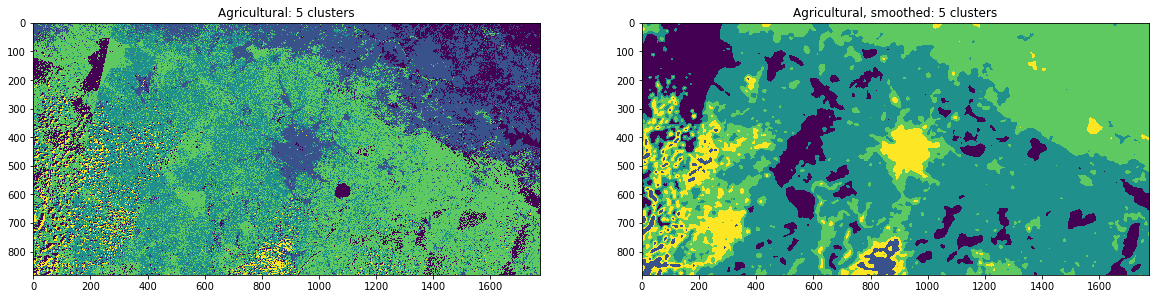

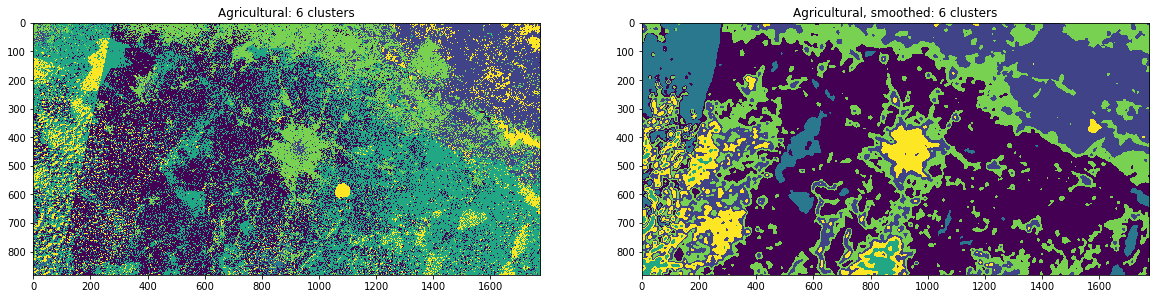

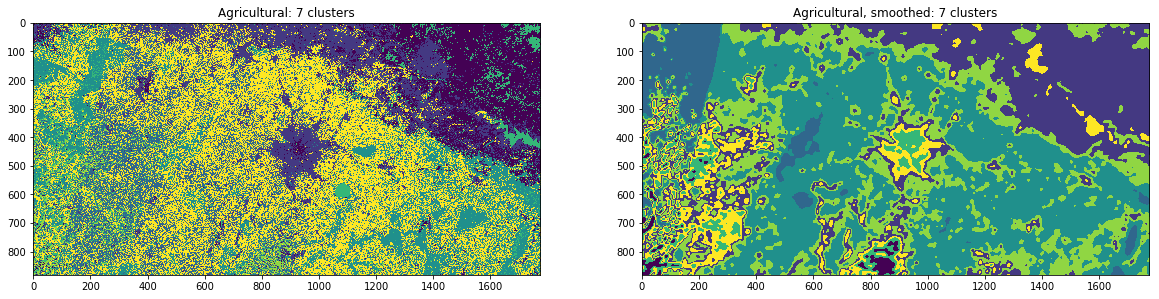

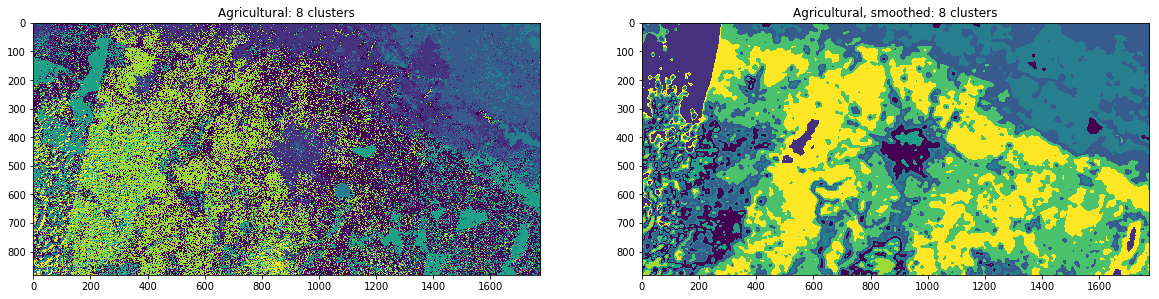

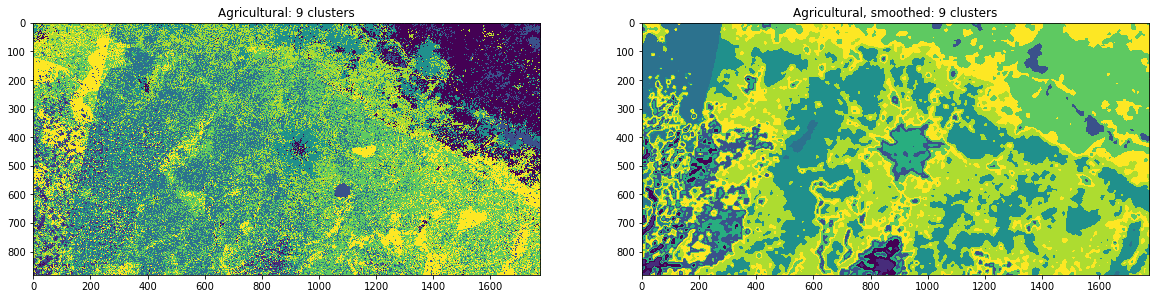

In [270]:
plt_results(ks = range(3,10), 
            imgs = agric_results,
            smoothed_imgs = smooth_agric_results, 
            img_name = "Agricultural"
           )

### Results

#### Images

This shows similar results to the natural image. Clustering on the smoothed image more promising.

With three groups, it looks able to seperate out the more mountainous areas with. clouds and agricultural/urban areas. Not quite what we want.

With 4 and 5, you can pick out the urban areas of the city and surrounding towns quite well. As you add more clusters it appears to gradually get more noise and appears less useful.

## Urban image

Like the Agricultural image, this has been pre-processed except, to pick out urban areas instead of agricutural.

In [271]:
urban_results = cluster_ks(images["Urban"], range(3,10))
smooth_urb_results = cluster_ks(smooth_images["Urban"], range(3,10))

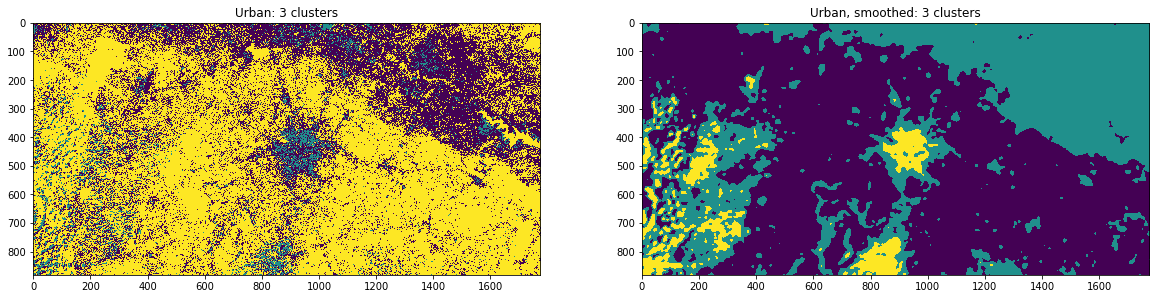

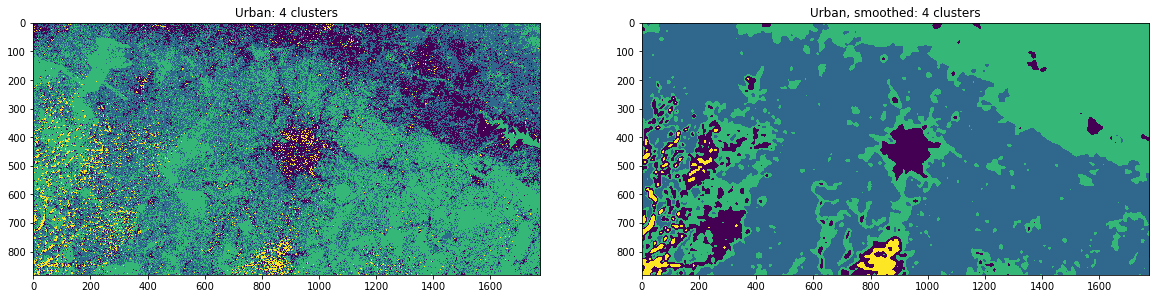

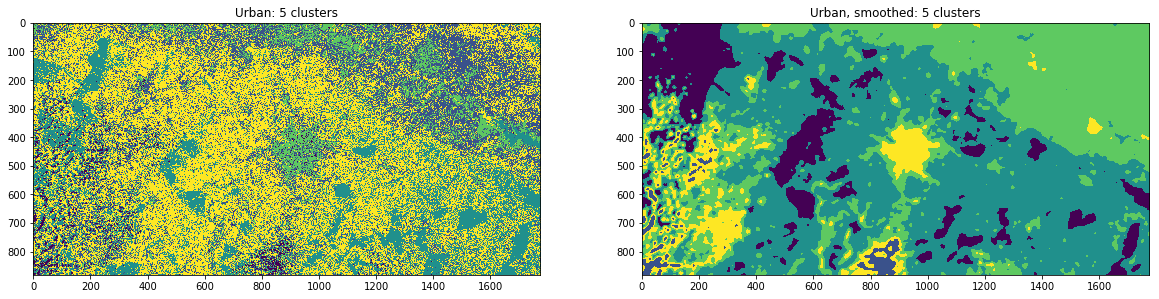

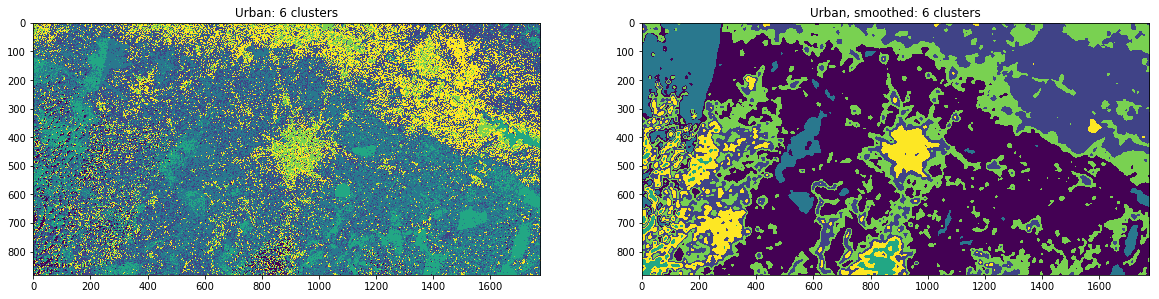

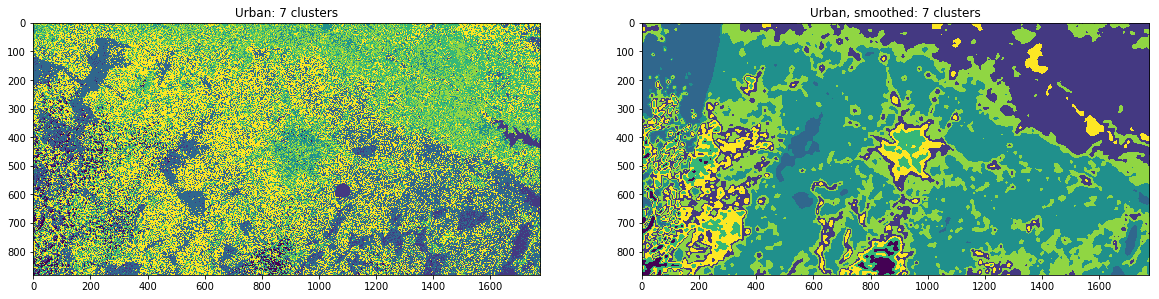

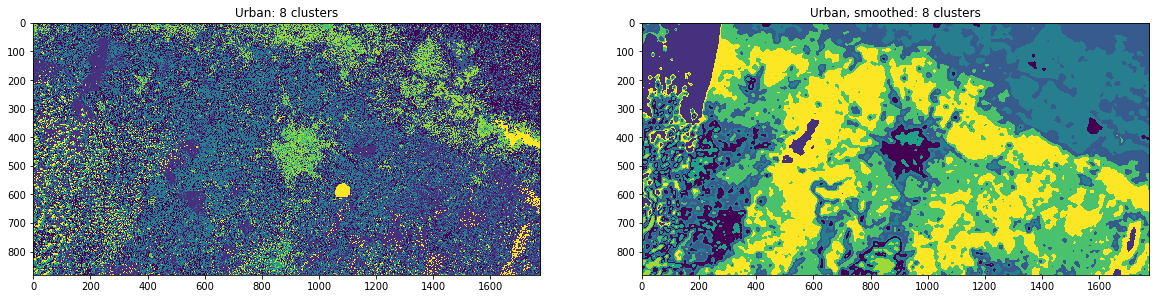

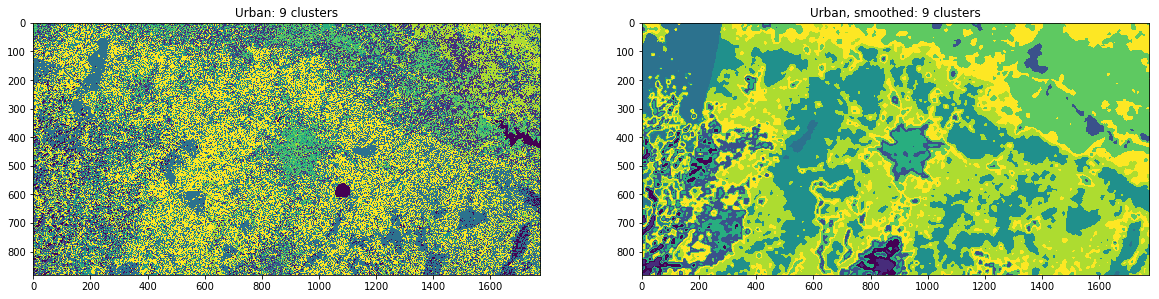

In [273]:
plt_results(ks = range(3,10), 
            imgs = urban_results,
            smoothed_imgs = smooth_urb_results, 
            img_name = "Urban"
           )

### Results

### images

As with the previous two images, four and five clusters show differences between the surrounding grassland and the city in the centre, but struggle to sepearate the city from the clouds while adding more clusters just adds more noise to the result. 



## Vegetation image

This image uses parts of the infared spectrum to show areas of vegetation so may be able to seperate out the urban areas from the city.

In [275]:
veg_results = cluster_ks(images["Vegetation"], range(3,10))
smooth_veg_results = cluster_ks(smooth_images["Vegetation"], range(3,10))

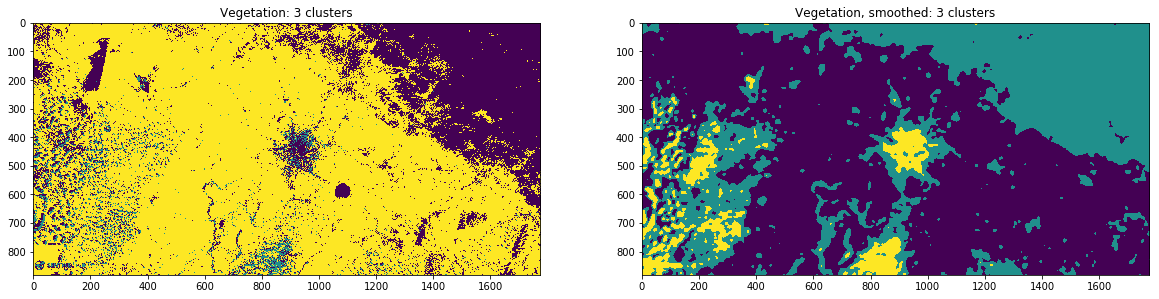

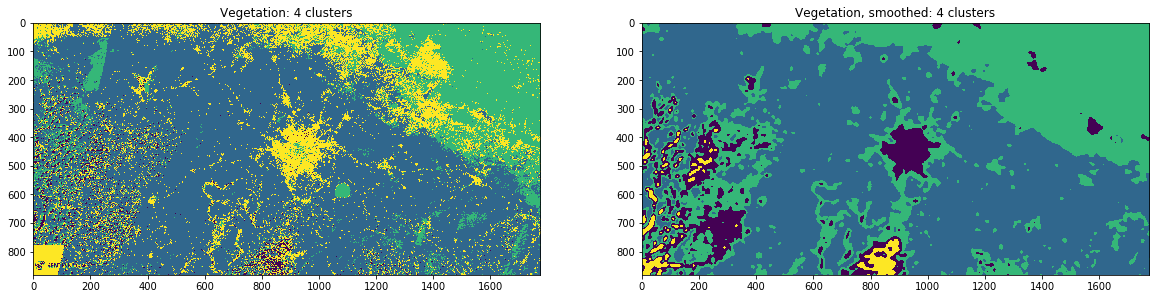

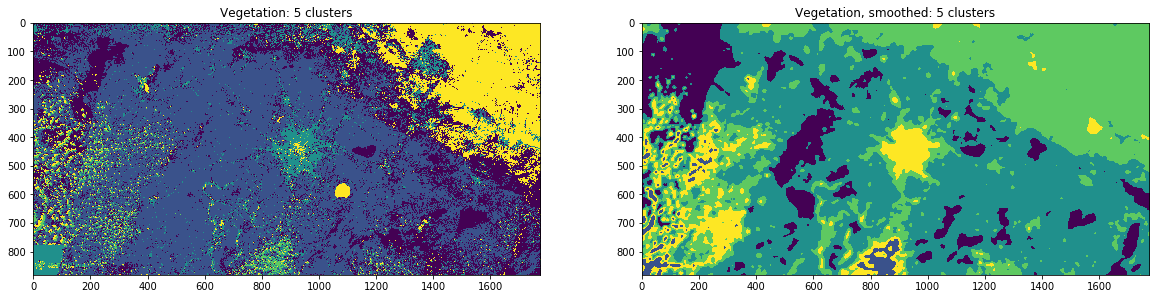

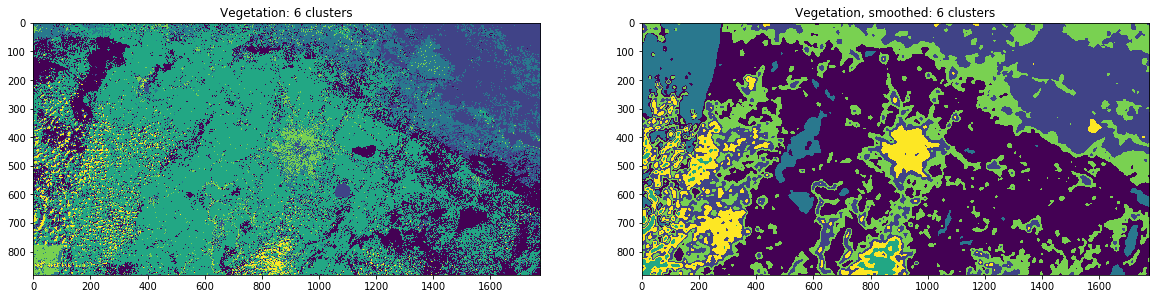

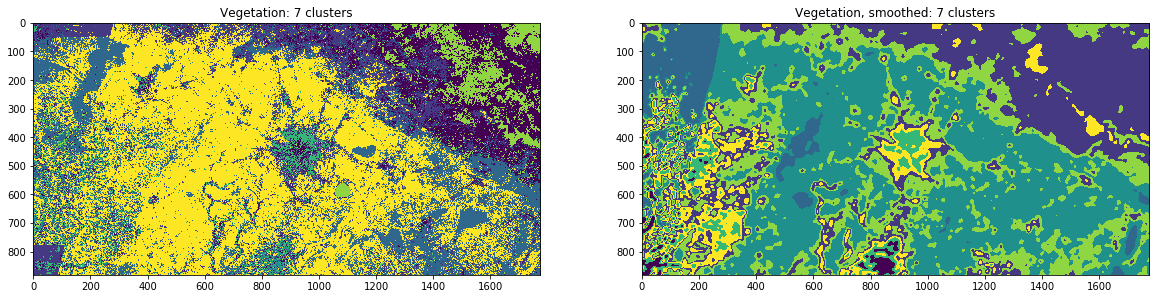

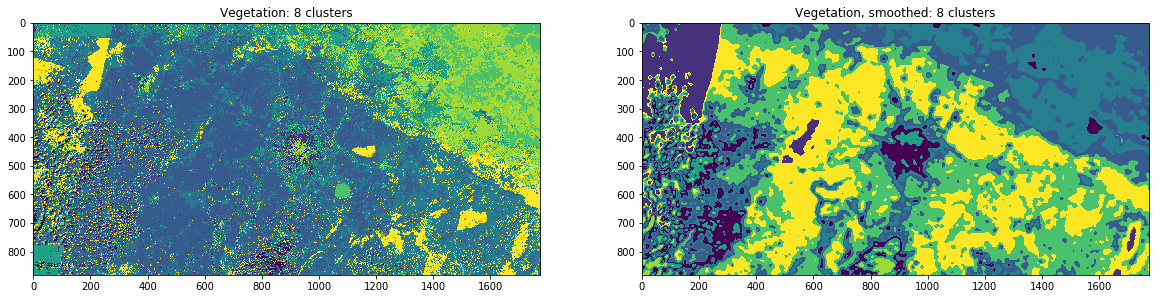

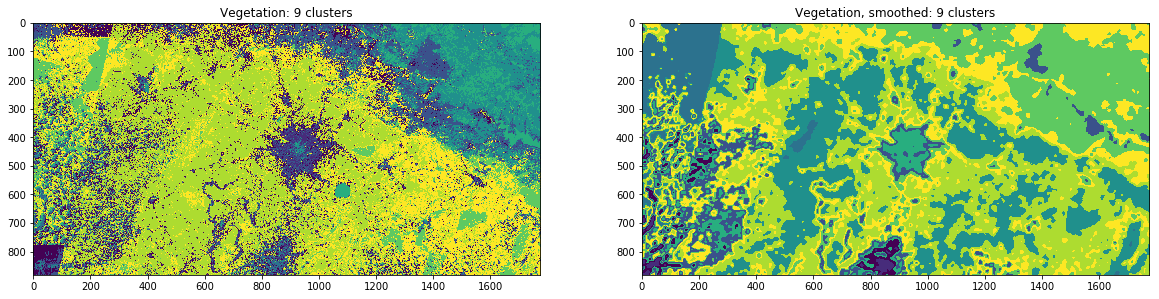

In [277]:
plt_results(ks = range(3,10), 
            imgs = veg_results,
            smoothed_imgs = smooth_veg_results, 
            img_name = "Vegetation"
           )

### Results

#### images
 

Otherwise it is simlar to before with more clusters after 6, just adding noise.

## Combining the images

In machine learning, more data is generally better *if* the data is relevant to the problem you are trying to solve. Since all the images appear to go some way to helping us, it makes sense to combine the data and repeat the k-means.

In [217]:
all_img = np.concatenate([images["Natural"], 
                          images["Vegetation"],
                          images["Urban"],
                          images["Agricultural"]
                         ],
                         axis = 2
                        )

images["Combined"] = all_img

all_smooth_img = np.concatenate([smooth_images["Natural"], 
                                 smooth_images["Vegetation"],
                                 smooth_images["Urban"],
                                 smooth_images["Agricultural"]
                                ],
                                axis = 2
                               )

smooth_images["Combined"] = all_smooth_img

In [279]:
combo_results = cluster_ks(images["Combined"], range(3,10))
smooth_combo_results = cluster_ks(smooth_images["Combined"], range(3,10))

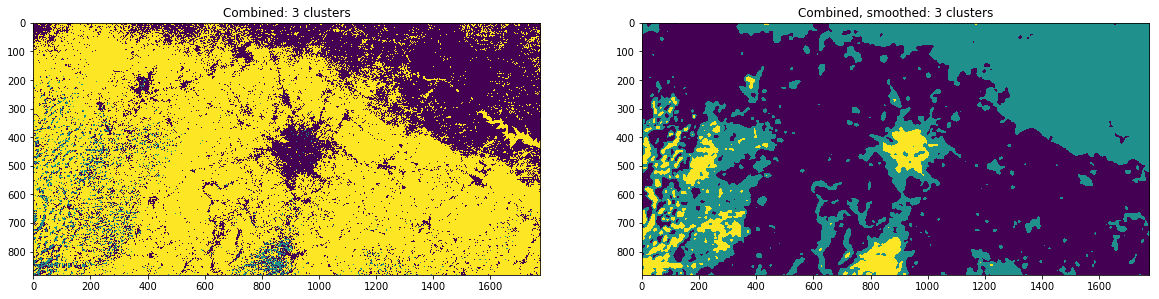

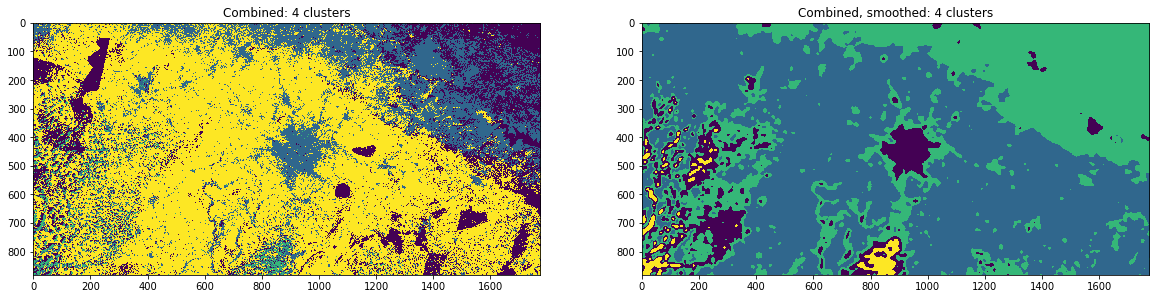

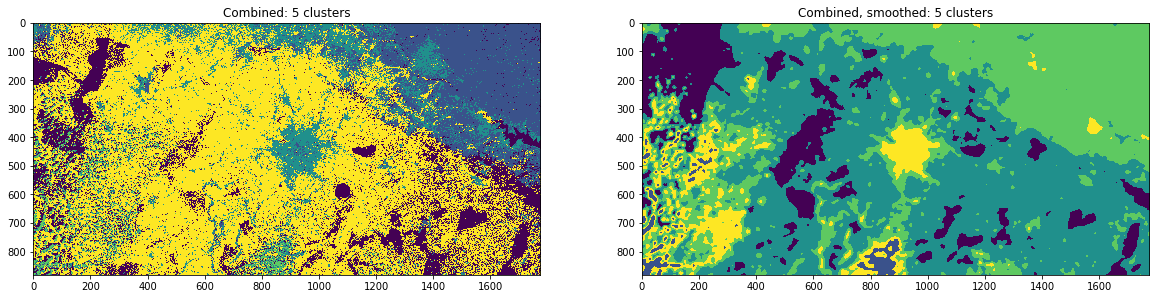

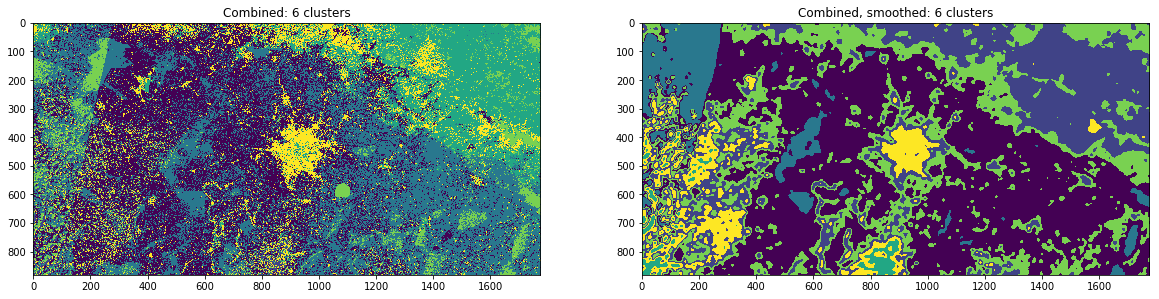

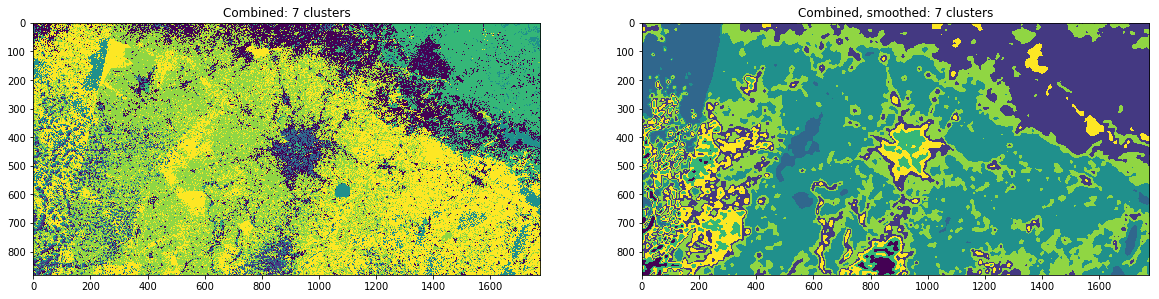

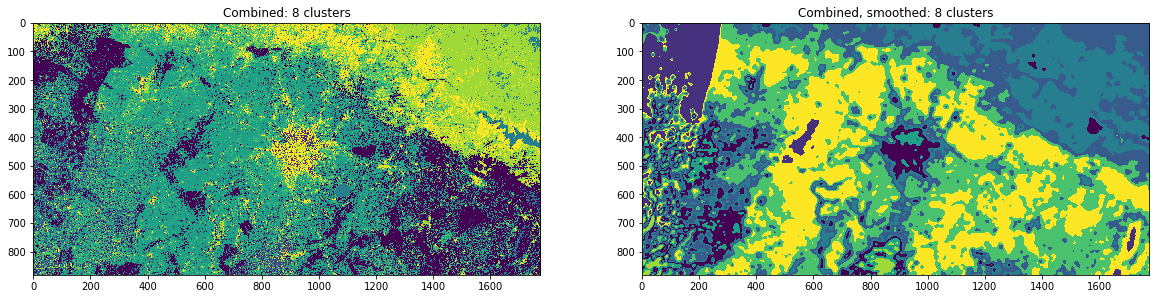

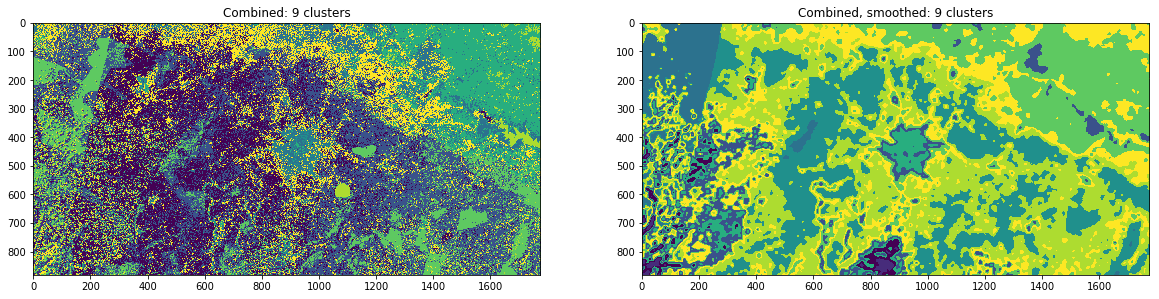

In [281]:
plt_results(ks = range(3,10), 
            imgs = combo_results,
            smoothed_imgs = smooth_combo_results, 
            img_name = "Combined"
           )

### Results

#### images
It is a similar story for our combined image dataset. Four and five.

## Overall 

- Smoothed images appear better for gross segmentation
- Clouds get grouped in with terrian, ideally any images will need to be free of clouds. 
- Unsupervised methods may be of some use. If images can come with gis data, it may be possible to use this information as labels in a superivsed machine learning approach which could be more useable.
